<a href="https://colab.research.google.com/github/spriyam095/LeuronN/blob/master/CannyEdgeDetection/ImageEdgeDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Canny Edge Detection on Face Images**

The objective is to take input the RGB images and get their major edges as an output.

Lets get started!!

Importing required libraries.

In [0]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as mpimg
import os
import scipy.misc as sm
from skimage.color import rgb2gray

Loading the images as data and converting RGB to grayscale.

In [0]:
def load_data(dir_name = 'abcd'):    
    '''
    Load images from the "faces_imgs" directory
    Images are in JPG and we convert it to gray scale images
    '''
    imgs = []
    for filename in os.listdir(dir_name):
        img = mpimg.imread(dir_name + '/' + filename)
        img = rgb2gray(img)
        imgs.append(img)
    return imgs
    
    
plates = load_data()

Looking at the input images after converting them to grayscale.

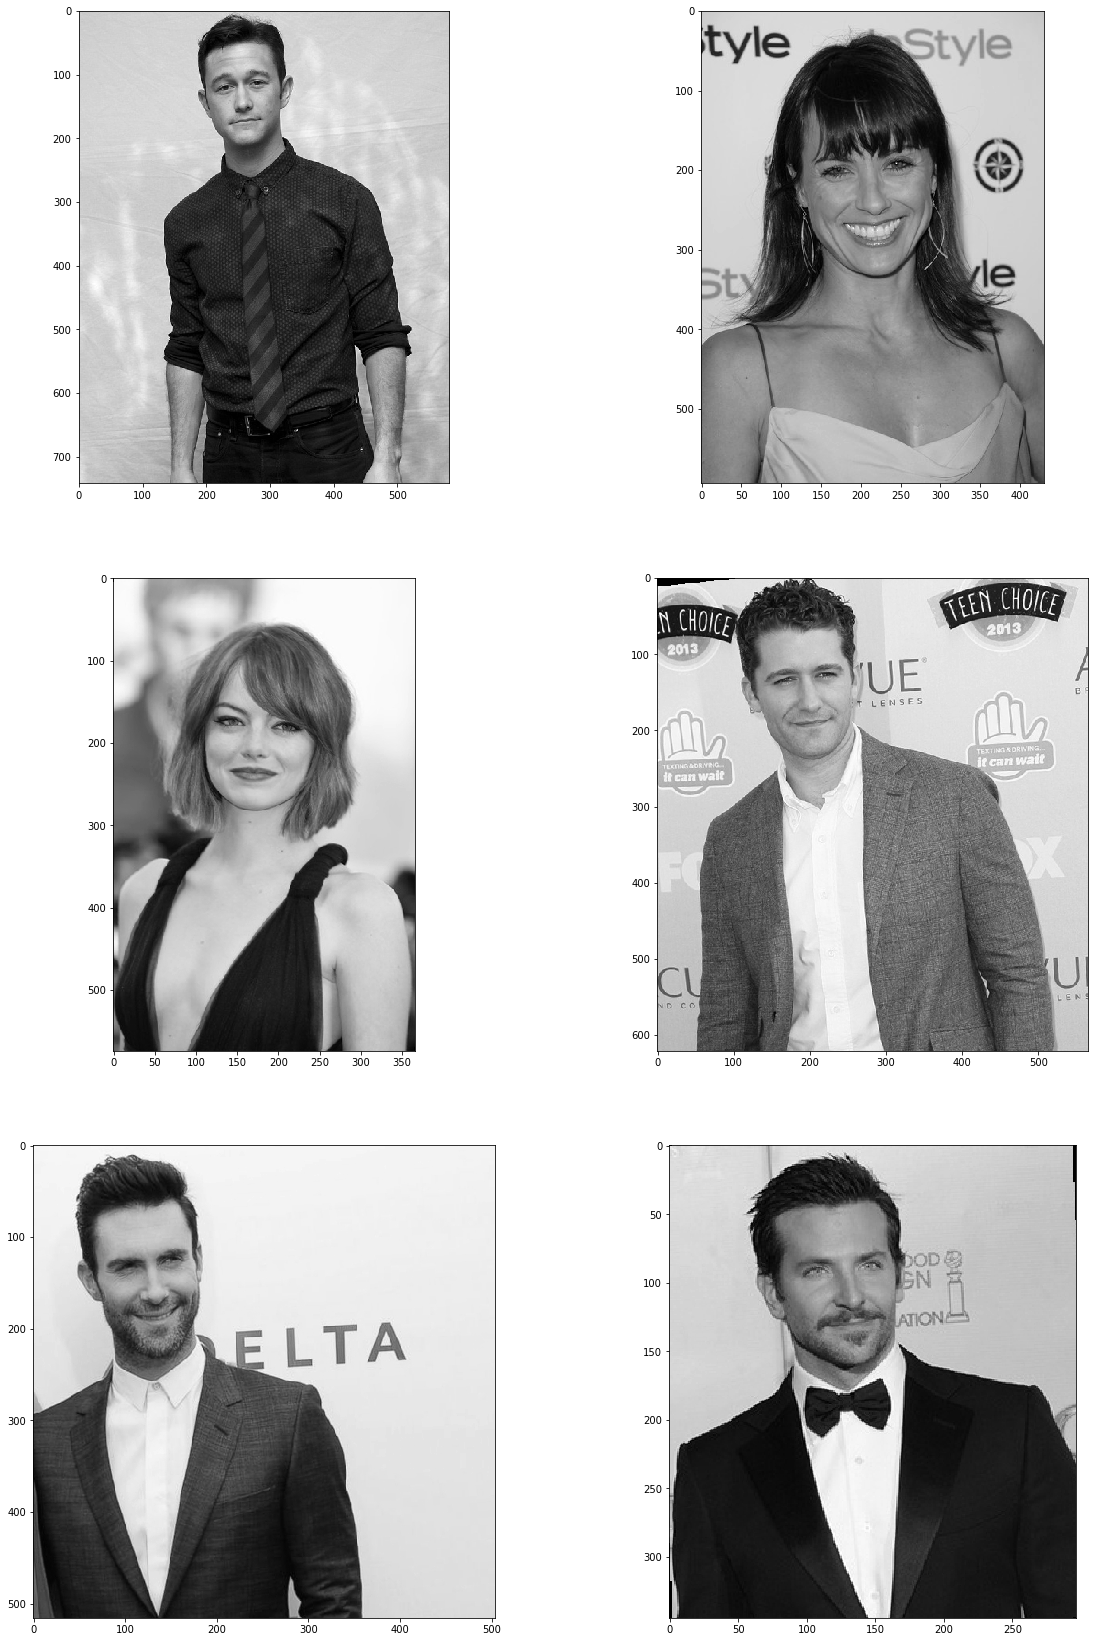

In [128]:
# The auxiliary function `visualize()` displays the images given as argument.
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(4, 2, plt_idx)    
        plt.imshow(img, cmap = plt.cm.gray)
    plt.show()

visualize(plates)

Defining "Gaussian kernel" to blurr the background of the image.

In [0]:
  def gaussian_kernel(size, sigma=1):

    size = int(size)//2

    x,y    = np.mgrid[-size:size+1 , -size:size+1]
    normal = 1/(2*np.pi*sigma**2)
    gauss  = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))*normal

    return gauss


Defining "Sobel filters" to capture the edges in the images in horizantal as well as vertical direction.

In [0]:
  def sobel_filters(image):
    kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32)
    ky = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], np.float32)
    
    Ix = ndimage.filters.convolve(image,kx)
    Iy = ndimage.filters.convolve(image,ky)

    gradient = np.hypot(Ix,Iy)
    gradient = gradient/gradient.max() *255

    theta = np.arctan2(Iy,Ix)
    
    return (gradient,theta)


Performing "Non-Max-Suppression" to find the pixels with the maximum intensity in the given direction of the edge in an image.

In [0]:
  def non_max_suppression(image, D):
    M,N = image.shape
    Z   = np.zeros((M,N), dtype=np.int32)
    
    angle = D*180./np.pi

    angle[angle<0]+=180

    for i in range(1,M-1):
      for j in range(1,N-1):

        try:
          q=255
          r=255

          if(0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):   #angle 0 
            
            q = image[i,j+1]
            r = image[i,j-1]
          
          elif(22.5 <= angle[i,j] < 67.5):                              #angle 45
            q = image[i-1,j+1]
            r = image[i+1,j-1]

          elif(67.5 <= angle[i,j] < 112.5):                             #angle 90
            q = image[i-1,j]
            r = image[i+1,j]

          elif(112.5 <= angle[i,j] < 157.5):                            #angle 135
            q = image[i-1,j-1]
            r = image[i+1,j+1]
          
          
          if image[i,j]>=q and image[i,j]>=r:
            Z[i,j] = image[i,j]
          else:
            Z[i,j] = 0 
        
        except IndexError as e:
          pass

    return Z
                                          


Implementing "Double threshold" to identify different types of pixels in image- (1) Strong->(higher than threshold) , (2) Weak->(between high and low threshold), (3) Others->(pixels of no meaning in the image)

In [0]:
  def threshold(image, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = image.max()*highThresholdRatio
    lowThreshold  = highThreshold*lowThresholdRatio

    M,N = image.shape 
    
    res = np.zeros((M,N), dtype = np.int32)
    
    weak   = np.int32(25)
    strong = np.int32(255)
    
    strong_i , strong_j = np.where(image>=highThreshold)
    zeros_i , zeros_j   = np.where(image<lowThreshold)
    weak_i , weak_j     = np.where((image<highThreshold) & (image>=lowThreshold))

    res[weak_i , weak_j]     = weak
    res[strong_i , strong_j] = strong
    
    return(res,weak,strong)

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one.

In [0]:
  def hystersis(image, weak=25, strong=255):
    
    M,N    = image.shape

    for i in range(1,M-1):
      for j in range(1,N-1):
        
        if image[i,j]==weak:
          
          try:
            
            if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong) or (image[i, j-1] == strong) 
                                            or (image[i, j+1] == strong) or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) 
                                            or (image[i-1, j+1] == strong)):
              image[i,j]=strong
            else:
              image[i,j]=0

          except IndexError as e:
            pass

    return image


Importing additional required libraries.

In [0]:
from scipy import ndimage
from scipy.ndimage.filters import convolve

Defining our base method to pass our images to the above defined methods.

In [0]:

def detect(image):

  image_smoothed                    = convolve(image, gaussian_kernel(5,sigma=1.4))
  gradientMat, thetaMat             = sobel_filters(image_smoothed)
  image_nonMax                      = non_max_suppression(gradientMat, thetaMat)
  image_threshold,weak,strong       = threshold(image_nonMax,lowThresholdRatio=0.07, highThresholdRatio=0.19)
  images_final                      = hystersis(image_threshold,weak,strong)

    
  return images_final


Passing the images to detect method to get the desierd edges in an image.

Processsing image1...
Processsing image2...
Processsing image3...
Processsing image4...
Processsing image5...
Processsing image6...


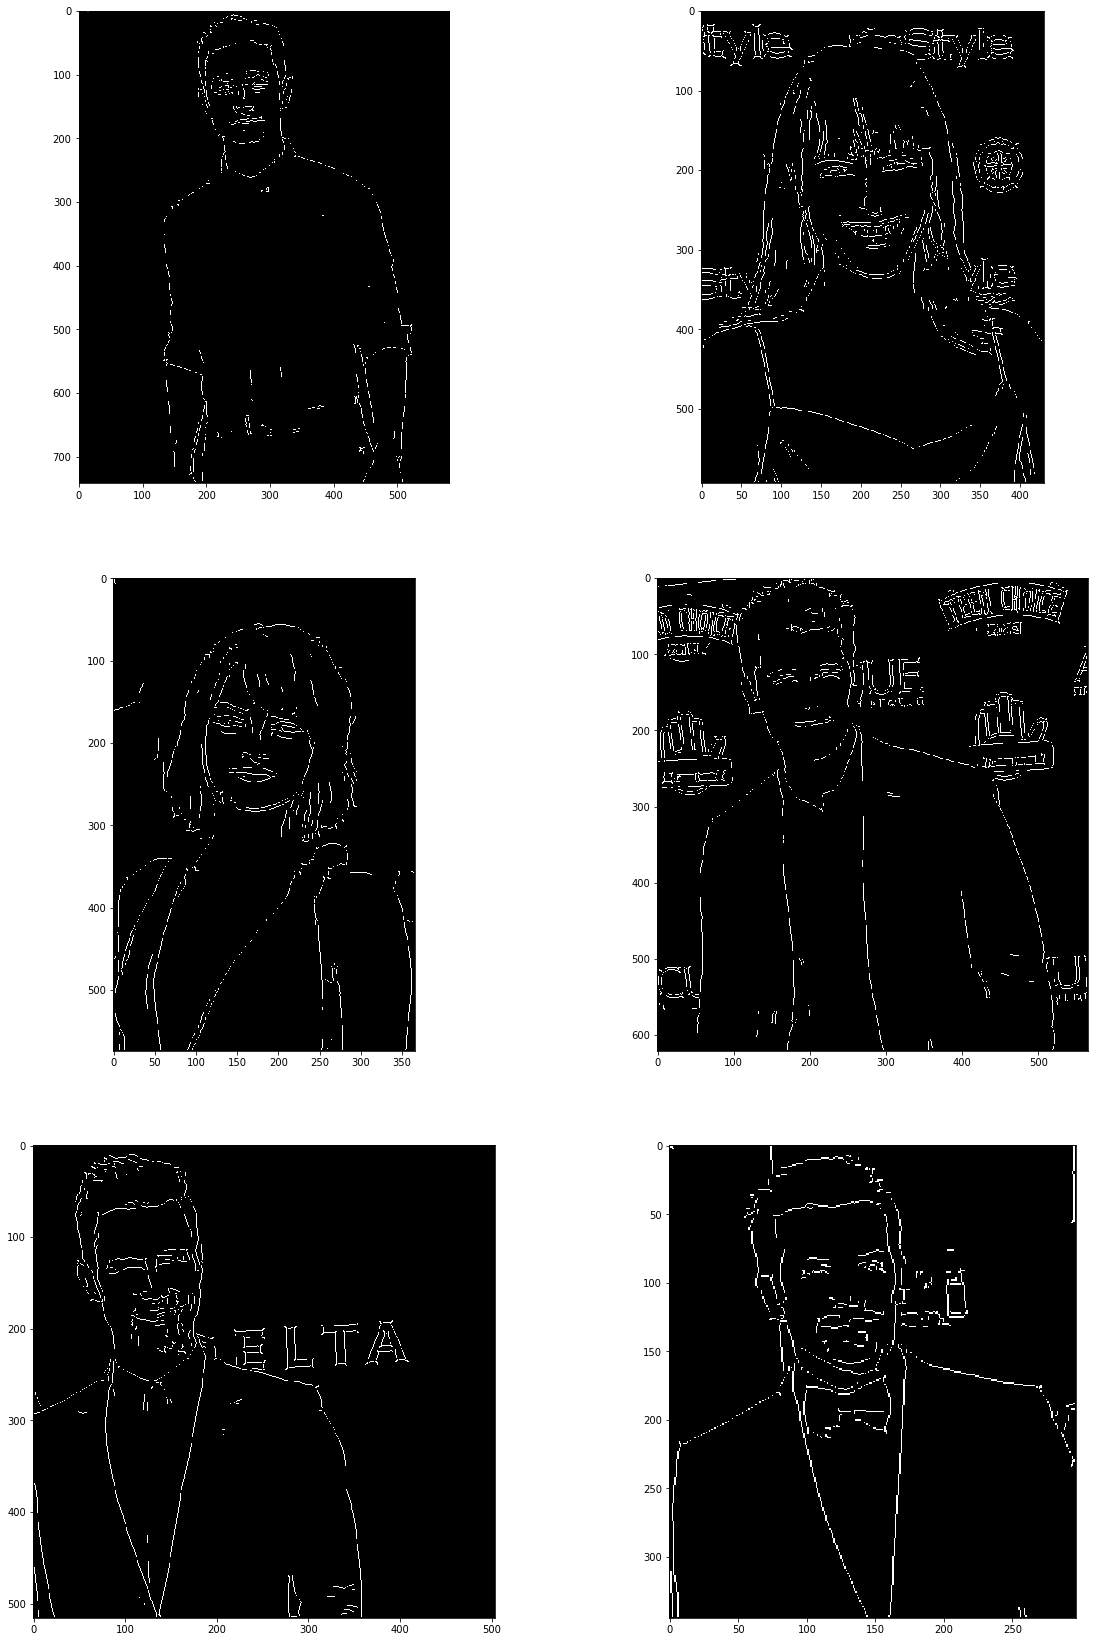

In [142]:
detect_image=[]

for i,image in enumerate(plates):
  print("Processsing image"+str(i+1)+"...")
  img = detect(image)
  detect_image.append(img)

visualize(detect_image)

And there we get some pretty good results.